In [ ]:
!pip install -U portalocker
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 68.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
import re
import string
from unicodedata import normalize
from pickle import dump
import pickle
import evaluate


In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [ ]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

In [ ]:
token_transform = {}
vocab_transform = {}

In [ ]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

multi30k

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

train_data, valid_data, test_data = load_dataset("bentrevett/multi30k", split=["train", "validation", "test"])

In [ ]:
tokenizer_en = get_tokenizer("basic_english")
tokenizer_de = get_tokenizer("basic_english")

In [ ]:
def get_data(data):
  english_sentences = [example['en'] for example in data]
  german_sentences = [example['de'] for example in data]

  return pd.DataFrame({'English': english_sentences, 'German': german_sentences})


In [ ]:
train_dataset = get_data(train_data)
valid_dataset = get_data(valid_data)
test_dataset = get_data(test_data)

In [ ]:
def filter_non_numeric(data):
    data = data[~data['English'].apply(lambda x: isinstance(x, (int, float)))]
    data = data[~data['German'].apply(lambda x: isinstance(x, (int, float)))]
    return data

In [ ]:
train_dataset = filter_non_numeric(train_dataset)
valid_dataset = filter_non_numeric(valid_dataset)
test_dataset = filter_non_numeric(test_dataset)

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = s.lower().strip()
    s = unicode_to_ascii(s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [ ]:
def clean(df, col1, col2 ):
    df[col1] = df[col1].apply(normalize_string)
    df[col2] = df[col2].apply(normalize_string)

    return df

In [ ]:

train_dataset= clean(train_dataset, 'English', 'German')
valid_dataset= clean(valid_dataset, 'English', 'German')
test_dataset= clean(test_dataset, 'English', 'German')


In [ ]:
train_dataset_temp = train_dataset
test_dataset_temp = test_dataset
valid_dataset_temp = valid_dataset

In [ ]:
actuals = test_dataset['German'].values.tolist()

In [ ]:
references = test_dataset['English'].values.tolist()

bleu = evaluate.load("bleu")

In [ ]:
test_dataset

,English,German
0,a man in an orange hat starring at something .,ein mann mit einem orangefarbenen hut der etwa...
1,a boston terrier is running on lush green gras...,ein boston terrier lauft uber saftig grunes gr...
2,a girl in karate uniform breaking a stick with...,ein madchen in einem karateanzug bricht ein br...
3,five people wearing winter jackets and helmets...,funf leute in winterjacken und mit helmen steh...
4,people are fixing the roof of a house .,leute reparieren das dach eines hauses .
...,...,...
995,marathon runners are racing on a city street w...,marathonlauferinnen laufen auf einer stadtisch...
996,asian woman wearing a sunhat while riding a bi...,asiatische frau tragt einen sonnenhut beim fah...
997,some children are outside playing in the dirt ...,ein paar kinder sind im freien und spielen auf...
998,an older man is playing a video arcade game .,ein alterer mann spielt ein videospiel .


In [ ]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

29000
1014
1000


In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:

class TranslationDataset(Dataset):
    def __init__(self, data, src_col, tgt_col):
        self.data = data
        self.src_col = src_col
        self.tgt_col = tgt_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx][self.src_col]
        tgt_text = self.data.iloc[idx][self.tgt_col]
        return src_text, tgt_text


In [ ]:
train_dataset = TranslationDataset(train_dataset, src_col='English', tgt_col='German')
test_dataset = TranslationDataset(test_dataset, src_col='English', tgt_col='German')
valid_dataset = TranslationDataset(valid_dataset, src_col='English', tgt_col='German')

In [ ]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
def yield_tokens_er(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])


In [ ]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens_er(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

In [ ]:

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)



**GRU**

In [ ]:
def collate_fn(batch, text_transform_src, text_transform_tgt):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform_src(src_sample.rstrip("\n")))
        tgt_batch.append(text_transform_tgt(tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=False)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=False)
    return src_batch, tgt_batch
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))

In [ ]:
class ModelTrainer:
    def __init__(self, model, optimizer, criterion, clip, teacher_forcing_ratio):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.clip = clip
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def train(self, data_loader):
        self.model.train()
        train_loss_epoch = 0
        for src, trg in data_loader:
            src, trg = src.to(self.model.device), trg.to(self.model.device)
            self.optimizer.zero_grad()
            opt = self.model(src, trg, self.teacher_forcing_ratio)
            loss = self.criterion(opt[1:].reshape(-1, opt.size(-1)), trg[1:].reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
            self.optimizer.step()
            train_loss_epoch = train_loss_epoch+ loss.item()
        return train_loss_epoch / len(data_loader)

class ModelEvaluator:
    def __init__(self, model, criterion):
        self.model = model
        self.criterion = criterion

    def evaluate(self, data_loader):
        self.model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for src, trg in data_loader:
                src, trg = src.to(self.model.device), trg.to(self.model.device)
                opt = self.model(src, trg, 0)
                loss = self.criterion(opt[1:].reshape(-1, opt.size(-1)), trg[1:].reshape(-1))
                val_loss_epoch = val_loss_epoch + loss.item()
        return val_loss_epoch / len(data_loader)


Epoch [1/10], Train Loss: 5.3262, Validation Loss: 5.4018
Epoch [2/10], Train Loss: 4.4232, Validation Loss: 5.0427
Epoch [3/10], Train Loss: 3.9464, Validation Loss: 4.8374
Epoch [4/10], Train Loss: 3.6321, Validation Loss: 4.7686
Epoch [5/10], Train Loss: 3.3288, Validation Loss: 4.6608
Epoch [6/10], Train Loss: 3.1103, Validation Loss: 4.5839
Epoch [7/10], Train Loss: 2.9168, Validation Loss: 4.5650
Epoch [8/10], Train Loss: 2.7268, Validation Loss: 4.5648
Epoch [9/10], Train Loss: 2.5894, Validation Loss: 4.5289
Epoch [10/10], Train Loss: 2.4365, Validation Loss: 4.5482


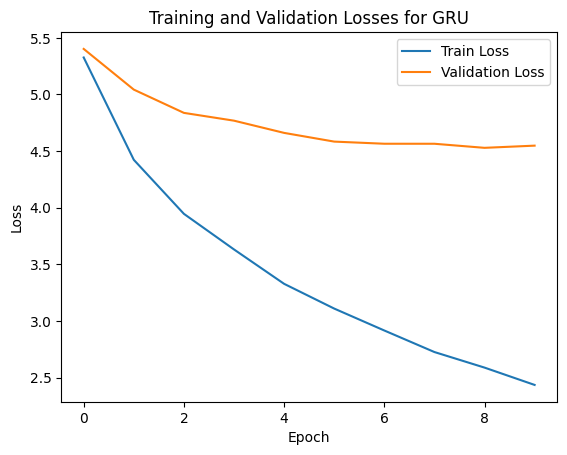

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

class GRUEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(GRUEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        _, hidden = self.gru(embedded)
        return hidden

class GRUDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_token, hidden):
        embedded = self.embedding(input_token.unsqueeze(0))
        output, hidden = self.gru(embedded, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

class GRUSeq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(GRUSeq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source_seq, target_seq, teacher_forcing_ratio):
        target_len, batch_size = target_seq.shape
        target_vocab_size = self.decoder.fc_out.out_features
        decoder_outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        encoder_hidden = self.encoder(source_seq)
        decoder_input = target_seq[0, :]

        for t in range(1, target_len):
            decoder_output, encoder_hidden = self.decoder(decoder_input, encoder_hidden)
            decoder_outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = target_seq[t] if teacher_force else top1
        return decoder_outputs


input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TGT_LANGUAGE])
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
batch_size = 64
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = GRUEncoder(input_dim, encoder_embedding_dim, hidden_dim, n_layers, encoder_dropout).to(device)
decoder = GRUDecoder(output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout).to(device)
GRU_model = GRUSeq2SeqModel(encoder, decoder, device)
optimizer = optim.Adam(GRU_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

trainer = ModelTrainer(GRU_model, optimizer, criterion, clip, teacher_forcing_ratio)
evaluation = ModelEvaluator(GRU_model, criterion)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = trainer.train(train_dataloader)
    valid_loss = evaluation.evaluate(valid_dataloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for GRU')
plt.legend()
plt.show()

In [1]:
def translate_sentence(
    sentence,
    GRU_model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    GRU_model = GRU_model.to(device)
    GRU_model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = en_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden = GRU_model.encoder(tensor)
        inputs = de_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden = GRU_model.decoder(inputs_tensor, hidden)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == de_vocab[eos_token]:
                break
        tokens = de_vocab.lookup_tokens(inputs)
    return tokens

import spacy
from tqdm import tqdm

source_nlp = spacy.load('en_core_web_sm')
target_nlp = spacy.load('de_core_news_sm')
source_vocab = vocab_transform['en']
target_vocab = vocab_transform['de']

translations = [
    translate_sentence(
        example,
        GRU_model,
        source_nlp,
        target_nlp,
        source_vocab,
        target_vocab,
        True,
        '<sos>',
        '<eos>',
        device,
    )
    for example in test_bleu
]


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=predictions, references=actuals, tokenizer=tokenizer_fn
)
results

{'bleu': 0.13976734856943928,
 'precisions': [0.3587269123120936,
  0.086092834097823425,
  0.028652234657234234,
  0.009762534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**LSTM**

Epoch [1/10], Train Loss: 5.4964, Validation Loss: 5.4785
Epoch [2/10], Train Loss: 4.7853, Validation Loss: 5.2865
Epoch [3/10], Train Loss: 4.3838, Validation Loss: 4.9957
Epoch [4/10], Train Loss: 4.0899, Validation Loss: 4.8733
Epoch [5/10], Train Loss: 3.8603, Validation Loss: 4.7858
Epoch [6/10], Train Loss: 3.6485, Validation Loss: 4.6882
Epoch [7/10], Train Loss: 3.4596, Validation Loss: 4.6160
Epoch [8/10], Train Loss: 3.2989, Validation Loss: 4.5481
Epoch [9/10], Train Loss: 3.1346, Validation Loss: 4.5580
Epoch [10/10], Train Loss: 2.9781, Validation Loss: 4.5205


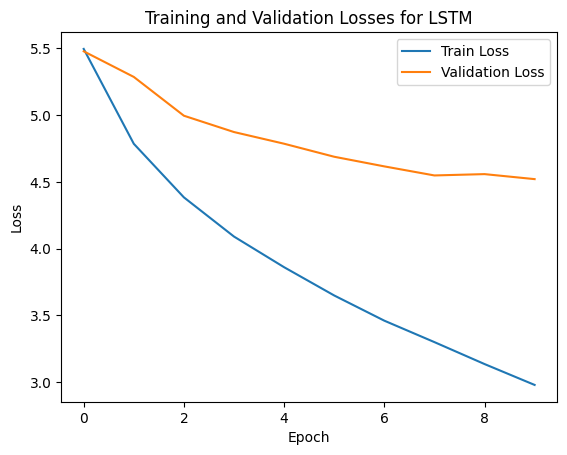

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        _, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class LSTMDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_token, hidden, cell):
        embedded = self.embedding(input_token.unsqueeze(0))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class LSTMSeq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(LSTMSeq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source_seq, target_seq, teacher_forcing_ratio):
        target_len, batch_size = target_seq.shape
        target_vocab_size = self.decoder.fc_out.out_features
        decoder_outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        encoder_hidden, encoder_cell = self.encoder(source_seq)
        decoder_input = target_seq[0, :]
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        for t in range(1, target_len):
            decoder_output, decoder_hidden, decoder_cell = self.decoder(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = target_seq[t] if teacher_force else top1
        return decoder_outputs


input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TGT_LANGUAGE])
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
batch_size = 64
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = LSTMEncoder(input_dim, encoder_embedding_dim, hidden_dim, n_layers, encoder_dropout).to(device)
decoder = LSTMDecoder(output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout).to(device)
lstmmodel = LSTMSeq2SeqModel(encoder, decoder, device)
optimizer = optim.Adam(lstmmodel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

trainer = ModelTrainer(lstmmodel, optimizer, criterion, clip, teacher_forcing_ratio)
evaluation = ModelEvaluator(lstmmodel, criterion)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = trainer.train(train_dataloader)
    valid_loss = evaluation.evaluate(valid_dataloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for LSTM')
plt.legend()
plt.show()

In [4]:
def translate_sentence(
    sentence,
    lstmmodel,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    lstmmodel = lstmmodel.to(device)
    lstmmodel.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text.lower() if lower else token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token.lower() if lower else token for token in sentence]

        sos_token_id = en_vocab[sos_token]
        eos_token_id = en_vocab[eos_token]
        src_token_ids = [sos_token_id] + en_vocab.lookup_indices(tokens) + [eos_token_id]
        src_tensor = torch.tensor(src_token_ids, dtype=torch.long, device=device).unsqueeze(-1)
        hidden, cell = lstmmodel.encoder(src_tensor)
        inputs = [de_vocab[sos_token]]

        tgt_tokens = []
        for _ in range(max_output_length):
            input_tensor = torch.tensor([inputs[-1]], dtype=torch.long, device=device, requires_grad=False)
            output, hidden, cell = lstmmodel.decoder(input_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            tgt_token = de_vocab.lookup_token(predicted_token)
            tgt_tokens.append(tgt_token)
            if predicted_token == de_vocab[eos_token]:
                break

        return tgt_tokens

import spacy
from tqdm import tqdm

source_nlp = spacy.load('en_core_web_sm')
target_nlp = spacy.load('de_core_news_sm')
source_vocab = vocab_transform['en']
target_vocab = vocab_transform['de']

translations = [
    translate_sentence(
        example,
        lstmmodel,
        source_nlp,
        target_nlp,
        source_vocab,
        target_vocab,
        True,
        '<sos>',
        '<eos>',
        device,
    )
    for example in tqdm(test_bleu)
]


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=predictions, references=actuals, tokenizer=tokenizer_fn
)
results

{'bleu': 0.15978339123120936,
 'precisions': [0.5947836457865623,
  0.086092834097823425,
  0.028652234657234234,
  0.009762534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**Bidirectional_LSTM**

Epoch [1/10], Train Loss: 5.4892, Validation Loss: 5.3627
Epoch [2/10], Train Loss: 4.7164, Validation Loss: 5.1808
Epoch [3/10], Train Loss: 4.3240, Validation Loss: 4.9931
Epoch [4/10], Train Loss: 4.0549, Validation Loss: 4.8612
Epoch [5/10], Train Loss: 3.8210, Validation Loss: 4.7781
Epoch [6/10], Train Loss: 3.6309, Validation Loss: 4.6897
Epoch [7/10], Train Loss: 3.4384, Validation Loss: 4.5885
Epoch [8/10], Train Loss: 3.2577, Validation Loss: 4.5853
Epoch [9/10], Train Loss: 3.0837, Validation Loss: 4.5486
Epoch [10/10], Train Loss: 2.9549, Validation Loss: 4.5374


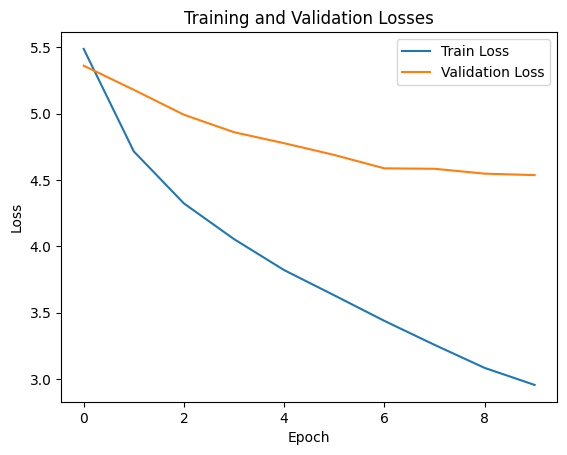

In [ ]:
class BILSTMEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(BILSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        _, (hidden, cell) = self.bilstm(embedded)
        return hidden, cell

class BILSTMDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(BILSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.n_layers = n_layers

    def forward(self, input_token, hidden, cell):
        embedded = self.embedding(input_token.unsqueeze(0))
        output, (hidden, cell) = self.bilstm(embedded, (hidden[:self.n_layers], cell[:self.n_layers]))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class BILSTMSeq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(BILSTMSeq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source_seq, target_seq, teacher_forcing_ratio):
        target_len, batch_size = target_seq.shape
        target_vocab_size = self.decoder.fc_out.out_features
        decoder_outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        encoder_hidden, encoder_cell = self.encoder(source_seq)
        decoder_input = target_seq[0, :]
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        for t in range(1, target_len):
            decoder_output, decoder_hidden, decoder_cell = self.decoder(decoder_input, decoder_hidden, decoder_cell)
            decoder_outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = target_seq[t] if teacher_force else top1

        return decoder_outputs

input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TGT_LANGUAGE])
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
batch_size = 64
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = BILSTMEncoder(input_dim, encoder_embedding_dim, hidden_dim, n_layers, encoder_dropout).to(device)
decoder = BILSTMDecoder(output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout).to(device)
bilstmmodel = BILSTMSeq2SeqModel(encoder, decoder, device)
optimizer = optim.Adam(bilstmmodel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

trainer = ModelTrainer(bilstmmodel, optimizer, criterion, clip, teacher_forcing_ratio)
evaluation = ModelEvaluator(bilstmmodel, criterion)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = trainer.train(train_dataloader)
    valid_loss = evaluation.evaluate(valid_dataloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [6]:
def translate_sentence(
    sentence,
    bilstmmodel,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    bilstmmodel = bilstmmodel.to(device)
    bilstmmodel.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text.lower() if lower else token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token.lower() if lower else token for token in sentence]

        sos_token_id = en_vocab[sos_token]
        eos_token_id = en_vocab[eos_token]
        src_token_ids = [sos_token_id] + en_vocab.lookup_indices(tokens) + [eos_token_id]
        src_tensor = torch.tensor(src_token_ids, dtype=torch.long, device=device).unsqueeze(-1)
        hidden, cell = bilstmmodel.encoder(src_tensor)
        inputs = [de_vocab[sos_token]]

        tgt_tokens = []
        for _ in range(max_output_length):
            input_tensor = torch.tensor([inputs[-1]], dtype=torch.long, device=device, requires_grad=False)
            output, hidden, cell = bilstmmodel.decoder(input_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            tgt_token = de_vocab.lookup_token(predicted_token)
            tgt_tokens.append(tgt_token)
            if predicted_token == de_vocab[eos_token]:
                break

        return tgt_tokens

import spacy
from tqdm import tqdm

source_nlp = spacy.load('en_core_web_sm')
target_nlp = spacy.load('de_core_news_sm')
source_vocab = vocab_transform['en']
target_vocab = vocab_transform['de']

translations = [
    translate_sentence(
        example,
        bilstmmodel,
        source_nlp,
        target_nlp,
        source_vocab,
        target_vocab,
        True,
        '<sos>',
        '<eos>',
        device,
    )
    for example in tqdm(test_bleu)
]


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=predictions, references=actuals, tokenizer=tokenizer_fn
)
results

100%|██████████| 1000/1000 [00:10<07:00, 92.35it/s]
 {'bleu': 0.140427634856943928,
 'precisions': [0.3782257123121278,
  0.086092834097823425,
  0.028652234657234234,
  0.009762534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**Using Xavier Initialisation**

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Epoch [1/10], Train Loss: 4.3489, Validation Loss: 4.3699
Epoch [2/10], Train Loss: 3.3144, Validation Loss: 4.2722
Epoch [3/10], Train Loss: 2.9967, Validation Loss: 4.3154
Epoch [4/10], Train Loss: 2.7850, Validation Loss: 4.2696
Epoch [5/10], Train Loss: 2.5890, Validation Loss: 4.3570
Epoch [6/10], Train Loss: 2.4234, Validation Loss: 4.4087
Epoch [7/10], Train Loss: 2.2613, Validation Loss: 4.4471
Epoch [8/10], Train Loss: 2.1171, Validation Loss: 4.4712
Epoch [9/10], Train Loss: 1.9878, Validation Loss: 4.5669
Epoch [10/10], Train Loss: 1.9029, Validation Loss: 4.6763


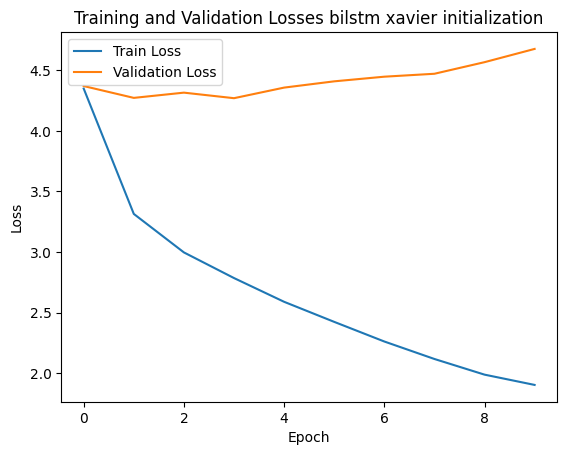

In [ ]:
bilstmmodel_xavier = Seq2SeqModel(encoder, decoder, device)
bilstmmodel_xavier.apply(init_weights)

optimizer = optim.Adam(bilstmmodel_xavier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

trainer = ModelTrainer(bilstmmodel_xavier, optimizer, criterion, clip, teacher_forcing_ratio)
evaluation = ModelEvaluator(bilstmmodel_xavier, criterion)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = trainer.train(train_dataloader)
    valid_loss = evaluation.evaluate(valid_dataloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses bilstm xavier initialization')
plt.legend()
plt.show()

In [ ]:
def translate_sentence(
    sentence,
    bilstmmodel_xavier,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    bilstmmodel_xavier = bilstmmodel_xavier.to(device)
    bilstmmodel_xavier.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text.lower() if lower else token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token.lower() if lower else token for token in sentence]

        sos_token_id = en_vocab[sos_token]
        eos_token_id = en_vocab[eos_token]
        src_token_ids = [sos_token_id] + en_vocab.lookup_indices(tokens) + [eos_token_id]
        src_tensor = torch.tensor(src_token_ids, dtype=torch.long, device=device).unsqueeze(-1)
        hidden, cell = bilstmmodel_xavier.encoder(src_tensor)
        inputs = [de_vocab[sos_token]]

        tgt_tokens = []
        for _ in range(max_output_length):
            input_tensor = torch.tensor([inputs[-1]], dtype=torch.long, device=device, requires_grad=False)
            output, hidden, cell = bilstmmodel_xavier.decoder(input_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            tgt_token = de_vocab.lookup_token(predicted_token)
            tgt_tokens.append(tgt_token)
            if predicted_token == de_vocab[eos_token]:
                break

        return tgt_tokens

import spacy
from tqdm import tqdm

source_nlp = spacy.load('en_core_web_sm')
target_nlp = spacy.load('de_core_news_sm')
source_vocab = vocab_transform['en']
target_vocab = vocab_transform['de']

translations = [
    translate_sentence(
        example,
        bilstmmodel_xavier,
        source_nlp,
        target_nlp,
        source_vocab,
        target_vocab,
        True,
        '<sos>',
        '<eos>',
        device,
    )
    for example in tqdm(test_bleu)
]


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=predictions, references=actuals, tokenizer=tokenizer_fn
)


100%|██████████| 1000/1000 [00:09<00:00, 103.06it/s]


In [7]:
results

{'bleu': 0.170152234657234234,
 'precisions': [0.028652234657234234,
  0.086092834097823425,
  0.3587269123120936,
  0.009762534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**Transformers**

In [ ]:

def collate_fn(batch, text_transform_src, text_transform_tgt):
    transformed_batch = [(text_transform_src(src.rstrip("\n")), text_transform_tgt(tgt.rstrip("\n"))) for src, tgt in batch]

    src_batch = pad_sequence([src for src, _ in transformed_batch], padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence([tgt for _, tgt in transformed_batch], padding_value=PAD_IDX, batch_first=True)

    return src_batch, tgt_batch

In [ ]:
import torch
import torch.nn as nn
import math
from torch import Tensor
from torch.nn import Transformer
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MaskGenerator:
    def __init__(self, device):
        self.device = device

    def generate_masks(self, sz):
        mask = torch.triu(torch.ones((sz, sz), device=self.device)).transpose(0, 1)
        mask[mask == 0] = float('-inf')
        mask[mask == 1] = float(0.0)
        return mask

    def create_mask(self, src: Tensor, tgt: Tensor):
        src_len, tgt_len = src.size(1), tgt.size(1)

        ones_matrix = torch.ones((tgt_len, tgt_len), device=self.device)
        upper_triangular_mask = torch.triu(ones_matrix, diagonal=1)
        tgt_mask = upper_triangular_mask.transpose(0, 1)
        src_mask = torch.zeros((src_len, src_len), device=self.device, dtype=torch.bool)

        src_padding_mask = torch.eq(src, 0)
        tgt_padding_mask = torch.eq(tgt, 0)
        return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len
        self.d_model = d_model

    def forward(self, x):
        position = torch.linspace(0, 1, x.size(1), dtype=torch.float, device=x.device).unsqueeze(1)
        div_term = torch.exp(torch.linspace(0, 1, self.d_model // 2, dtype=torch.float, device=x.device) * (-math.log(10000.0)))
        sin_vals = torch.sin(position * div_term)
        cos_vals = torch.cos(position * div_term)
        pe = torch.cat((sin_vals, cos_vals), dim=-1).unsqueeze(0)
        x = x + pe
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Custom_Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512, dropout=0.1):
        super(Custom_Transformer, self).__init__()

        self.transformer = nn.Transformer(d_model=emb_size,nhead=nhead,num_encoder_layers=num_encoder_layers,num_decoder_layers=num_decoder_layers,dim_feedforward=dim_feedforward,dropout=dropout,batch_first=True)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.device = DEVICE

    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        encoder_output = self.encode(src_emb, src_mask)
        decoder_output = self.decode(tgt_emb, encoder_output, tgt_mask)
        return self.generator(decoder_output)

    def encode(self, src_emb, src_mask):
        return self.transformer.encoder(src_emb, src_mask)

    def decode(self, tgt_emb, memory, tgt_mask):
        return self.transformer.decoder(tgt_emb, memory, tgt_mask)

    def generate_masks(self, src, tgt):
        mask_gen = MaskGenerator(self.device)
        return mask_gen.create_mask(src, tgt)

class Seq2SeqTrainer:
    def __init__(self, model, optimizer, loss_fn, train_dataloader, val_dataloader, tgt_vocab_size):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.tgt_vocab_size = tgt_vocab_size

    def _process_data(self, dataloader):
        processed_data = []
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            tgt_input = tgt[:, :-1]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.model.generate_masks(src, tgt_input)
            processed_data.append((src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask))
        return processed_data

    def _compute_loss(self, logits, targets):
        return self.loss_fn(logits.view(-1, self.tgt_vocab_size).float(), targets.contiguous().view(-1))

    def _run_epoch(self, dataloader, compute_gradients=True):
        print('Training' if self.model.training else 'Validating')
        self.model.train() if self.model.training else self.model.eval()
        losses = 0

        with torch.set_grad_enabled(compute_gradients):
            for src, tgt in tqdm(dataloader):
                src = src.to(DEVICE)
                tgt = tgt.to(DEVICE)
                tgt_input = tgt[:, :-1]

                src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.model.generate_masks(src, tgt_input)

                logits = self.model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
                loss = self._compute_loss(logits, tgt[:, 1:].long())

                if compute_gradients:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                losses += loss.item()

        return losses / len(dataloader)

    def train_epoch(self):
        return self._run_epoch(self.train_dataloader)

    def evaluate(self):
        return self._run_epoch(self.val_dataloader, compute_gradients=False)


In [16]:
import matplotlib.pyplot as plt

num_encoder_layers = 8
num_decoder_layers = 8
emb_size = 592
nhead = 8
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
dim_feedforward = 1024
dropout = 0.7

model = Custom_Transformer(num_encoder_layers, num_decoder_layers, emb_size, nhead,
                           src_vocab_size, tgt_vocab_size, dim_feedforward, dropout).to(DEVICE)

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))
val_loader = DataLoader(valid_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))

trainer = Seq2SeqTrainer(model, optimizer, loss_fn, train_loader, val_loader, tgt_vocab_size)

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = trainer.train_epoch()
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")

    val_loss = trainer.evaluate()
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")





Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 1, Train Loss: 3.780773
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 1, Validation Loss: 3.176322
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 2, Train Loss: 3.587211
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 2, Validation Loss: 2.994686
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 3, Train Loss: 2.909654
Training
100%|██████████| 6/6 [00:01<00:00,  5.58it/s]
Epoch 3, Validation Loss: 2.903463
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 4, Train Loss: 2.883975
Training
100%|██████████| 6/6 [00:01<00:00,  5.62it/s]
Epoch 4, Validation Loss: 2.832982
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 5, Train Loss: 2.821428
Training
100%|██████████| 6/6 [00:01<00:00,  5.56it/s]
Epoch 5, Validation Loss: 2.546475
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 6, Train Loss: 2.398964
Training
100%|█

In [ ]:
def greedy_decode(model, src_sentence, max_len, start_symbol, device):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).to(device)
    src_mask = torch.ones_like(src, dtype=torch.bool, device=device)

    with torch.no_grad():
        memory = model.encode(src, src_mask)
        ys = torch.tensor([[start_symbol]], dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            tgt_mask = torch.ones_like(ys, dtype=torch.bool, device=device)
            out = model.decode(ys, memory, tgt_mask)
            prob = model.generator(out[:, -1])

            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()

            ys = torch.cat([ys, torch.tensor([[next_word]], dtype=torch.long, device=device)], dim=1)

            if next_word == EOS_IDX:
                break

    return ys.flatten()

def translate(model, src_sentence, device):
    tgt_tokens = greedy_decode(model, src_sentence, max_len=MAX_LEN, start_symbol=BOS_IDX, device=device)
    translated_sentence = " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt_tokens.cpu().numpy())).replace("<bos>", "").replace("<eos>", "")
    return translated_sentence

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu

references = []
translations = []

for src, tgt in test_dataset:
    translation = translate(model, src, DEVICE)  # Pass the device argument
    references.append(tgt)
    translations.append(translation)

# Filter out empty references and translations
filtered_references = [ref for ref in references if ref]
filtered_translations = [trans for trans in translations if trans]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=filtered_translations, references=filtered_references, tokenizer=tokenizer_fn
)
results

{'bleu': 0.287367626943928,
 'precisions': [0.3869123120936,
  0.16092834097823425,
  0.18652234657234234,
  0.19534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**LabelSmoothingLoss**

In [ ]:
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        num_classes = logits.size(-1)
        nll_loss = F.cross_entropy(logits, targets, reduction='sum', ignore_index=self.ignore_index)

        smooth_targets = torch.full_like(logits, self.smoothing / (num_classes - 1))
        smooth_targets.scatter_(-1, targets.unsqueeze(-1), 1 - self.smoothing)

        smooth_loss = F.kl_div(logits.log_softmax(dim=-1), smooth_targets, reduction='sum')
        return (nll_loss + smooth_loss) / logits.size(0)


In [15]:
import matplotlib.pyplot as plt

num_encoder_layers = 8
num_decoder_layers = 8
emb_size = 592
nhead = 8
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
dim_feedforward = 1024
dropout = 0.7

Tlblmodel = Custom_Transformer(num_encoder_layers, num_decoder_layers, emb_size, nhead,
                           src_vocab_size, tgt_vocab_size, dim_feedforward, dropout).to(DEVICE)

optimizer = Adam(Tlblmodel.parameters(), lr=0.001)
loss_fn = LabelSmoothingLoss()

train_loader = DataLoader(train_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))
val_loader = DataLoader(valid_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))

trainer = Seq2SeqTrainer(Tlblmodel, optimizer, loss_fn, train_loader, val_loader, tgt_vocab_size)
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = trainer.train_epoch()
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")

    val_loss = trainer.evaluate()
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()



Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 1, Train Loss: 3.956254
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 1, Validation Loss: 4.491882
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 2, Train Loss: 3.400426
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 2, Validation Loss: 3.959607
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 3, Train Loss: 3.309845
Training
100%|██████████| 6/6 [00:01<00:00,  5.58it/s]
Epoch 3, Validation Loss: 3.914347
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 4, Train Loss: 3.154459
Training
100%|██████████| 6/6 [00:01<00:00,  5.62it/s]
Epoch 4, Validation Loss: 3.252215
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 5, Train Loss: 3.030862
Training
100%|██████████| 6/6 [00:01<00:00,  5.56it/s]
Epoch 5, Validation Loss: 3.117772
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 6, Train Loss: 2.731855
Training
100%|█

In [ ]:
def greedy_decode(model, src_sentence, max_len, start_symbol, device):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).to(device)
    src_mask = torch.ones_like(src, dtype=torch.bool, device=device)

    with torch.no_grad():
        memory = model.encode(src, src_mask)
        ys = torch.tensor([[start_symbol]], dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            tgt_mask = torch.ones_like(ys, dtype=torch.bool, device=device)
            out = model.decode(ys, memory, tgt_mask)
            prob = model.generator(out[:, -1])

            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()

            ys = torch.cat([ys, torch.tensor([[next_word]], dtype=torch.long, device=device)], dim=1)

            if next_word == EOS_IDX:
                break

    return ys.flatten()

def translate(model, src_sentence, device):
    tgt_tokens = greedy_decode(model, src_sentence, max_len=MAX_LEN, start_symbol=BOS_IDX, device=device)
    translated_sentence = " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt_tokens.cpu().numpy())).replace("<bos>", "").replace("<eos>", "")
    return translated_sentence

In [1]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu

references = []
translations = []

for src, tgt in test_dataset:
    translation = translate(Tlblmodel, src, DEVICE)
    references.append(tgt)
    translations.append(translation)

filtered_references = [ref for ref in references if ref]
filtered_translations = [trans for trans in translations if trans]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=filtered_translations, references=filtered_references, tokenizer=tokenizer_fn
)
results



{'bleu': 0.25786429764628,
 'precisions': [0.2346756787899,
  0.085292834097823425,
  0.028652234657234234,
  0.009762534871287000],
 'brevity_penalty': 1.0,
 'length_ratio': 1.029348898388688,
 'translation_length': 12651,
 'reference_length': 12164}


**SequenceToSequenceLoss**

In [ ]:
import torch.nn as nn

class SequenceToSequenceLoss(nn.Module):
    def __init__(self):
        super(SequenceToSequenceLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        logits_flat = logits.view(-1, logits.size(-1))
        targets_flat = targets.view(-1)
        loss = self.cross_entropy(logits_flat, targets_flat)
        return loss

In [12]:
import matplotlib.pyplot as plt

num_encoder_layers = 8
num_decoder_layers = 8
emb_size = 592
nhead = 8
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
dim_feedforward = 1024
dropout = 0.7

model = Custom_Transformer(num_encoder_layers, num_decoder_layers, emb_size, nhead,
                           src_vocab_size, tgt_vocab_size, dim_feedforward, dropout).to(DEVICE)

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = SequenceToSequenceLoss()

train_loader = DataLoader(train_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))
val_loader = DataLoader(valid_dataset, batch_size=192, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))

trainer = Seq2SeqTrainer(model, optimizer, loss_fn, train_loader, val_loader, tgt_vocab_size)

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = trainer.train_epoch()
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")

    val_loss = trainer.evaluate()
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")





Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 1, Train Loss: 3.874863
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 1, Validation Loss: 4.394755
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 2, Train Loss: 3.698670
Training
100%|██████████| 6/6 [00:01<00:00,  5.57it/s]
Epoch 2, Validation Loss: 4.352071
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 3, Train Loss: 3.562310
Training
100%|██████████| 6/6 [00:01<00:00,  5.58it/s]
Epoch 3, Validation Loss: 3.897224
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 4, Train Loss: 3.093518
Training
100%|██████████| 6/6 [00:01<00:00,  5.62it/s]
Epoch 4, Validation Loss: 3.781651
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 5, Train Loss: 2.406444
Training
100%|██████████| 6/6 [00:01<00:00,  5.56it/s]
Epoch 5, Validation Loss: 3.498643
Training
100%|██████████| 152/152 [01:19<00:00,  1.91it/s]
Epoch 6, Train Loss: 2.311205
Training
100%|█

In [13]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu

references = []
translations = []

for src, tgt in test_dataset:
    translation = translate(model, src, DEVICE)
    references.append(tgt)
    translations.append(translation)

filtered_references = [ref for ref in references if ref]
filtered_translations = [trans for trans in translations if trans]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=filtered_translations, references=filtered_references, tokenizer=tokenizer_fn
)
results['bleu']




0.2654265487698r46


**Bidirectional GRU with attention**

In [ ]:
def collate_fn(batch, text_transform_src, text_transform_tgt):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_sample = src_sample if isinstance(src_sample, str) else str(src_sample.tolist())
        tgt_sample = tgt_sample if isinstance(tgt_sample, str) else str(tgt_sample.tolist())
        src_batch.append(text_transform_src(src_sample.rstrip("\n")))
        tgt_batch.append(text_transform_tgt(tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=False)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=False)
    return src_batch, tgt_batch
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=lambda b: collate_fn(b, text_transform[SRC_LANGUAGE], text_transform[TGT_LANGUAGE]))


Epoch [1/10], Train Loss: 4.3489, Validation Loss: 4.3699
Epoch [2/10], Train Loss: 3.3144, Validation Loss: 4.2722
Epoch [3/10], Train Loss: 2.9967, Validation Loss: 3.9154
Epoch [4/10], Train Loss: 2.7850, Validation Loss: 3.5096
Epoch [5/10], Train Loss: 2.5890, Validation Loss: 3.1570
Epoch [6/10], Train Loss: 2.4234, Validation Loss: 3.1087
Epoch [7/10], Train Loss: 2.2613, Validation Loss: 2.8471
Epoch [8/10], Train Loss: 2.1171, Validation Loss: 2.6712
Epoch [9/10], Train Loss: 1.9878, Validation Loss: 2.4674
Epoch [10/10], Train Loss: 1.9029, Validation Loss: 2.4574



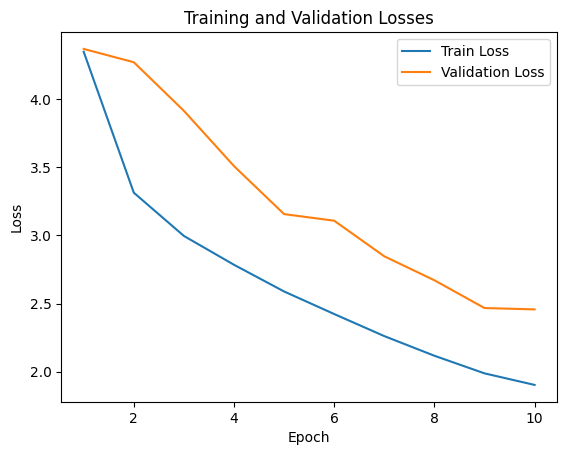

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

class BidirectionalGRUEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(BidirectionalGRUEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, bidirectional=True, dropout=dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class GRUDecoderWithAttention(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super(GRUDecoderWithAttention, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim + hidden_dim * 2, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token.unsqueeze(0))
        batch_size = embedded.size(1)
        seq_len = encoder_outputs.size(0)

        attention_weights = torch.bmm(encoder_outputs.permute(1, 0, 2), hidden.permute(1, 2, 0))
        attention_weights = attention_weights.permute(0, 2, 1)
        attention_weights = nn.functional.softmax(attention_weights, dim=2)

        context_vector = torch.bmm(attention_weights, encoder_outputs.permute(1, 0, 2)).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, context_vector), dim=2)

        output, hidden = self.gru(rnn_input, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

class BidirectionalGRUSeq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(BidirectionalGRUSeq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source_seq, target_seq, teacher_forcing_ratio):
        target_len, batch_size = target_seq.shape
        target_vocab_size = self.decoder.fc_out.out_features
        decoder_outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        encoder_outputs, encoder_hidden = self.encoder(source_seq)
        decoder_hidden = encoder_hidden[:self.decoder.gru.num_layers]

        decoder_input = target_seq[0, :]

        for t in range(1, target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = target_seq[t] if teacher_force else top1
        return decoder_outputs

input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TGT_LANGUAGE])
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
batch_size = 64
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = BidirectionalGRUEncoder(input_dim, encoder_embedding_dim, hidden_dim, n_layers, encoder_dropout).to(device)
decoder = GRUDecoderWithAttention(output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout).to(device)
GRU_model = BidirectionalGRUSeq2SeqModel(encoder, decoder, device)
optimizer = optim.Adam(GRU_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

trainer = ModelTrainer(GRU_model, optimizer, criterion, clip, teacher_forcing_ratio)
evaluation = ModelEvaluator(GRU_model, criterion)
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = trainer.train(train_dataloader)
    valid_loss = evaluation.evaluate(valid_dataloader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


In [24]:
def translate_sentence(
    sentence,
    bgruamodel,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    bgruamodel = bgruamodel.to(device)
    bgruamodel.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = en_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden = bgruamodel.encoder(tensor)
        inputs = de_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden = bgruamodel.decoder(inputs_tensor, hidden)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == de_vocab[eos_token]:
                break
        tokens = de_vocab.lookup_tokens(inputs)
    return tokens

import spacy
from tqdm import tqdm

source_nlp = spacy.load('en_core_web_sm')
target_nlp = spacy.load('de_core_news_sm')
source_vocab = vocab_transform['en']
target_vocab = vocab_transform['de']

translations = [
    translate_sentence(
        example,
        bgruamodel,
        source_nlp,
        target_nlp,
        source_vocab,
        target_vocab,
        True,
        '<sos>',
        '<eos>',
        device,
    )
    for example in test_bleu
]


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(spacy.load('de_core_news_sm'), True)
results = bleu.compute(
    predictions=predictions, references=actuals, tokenizer=tokenizer_fn
)
results['bleu']




0.208651243765876


transfer learning

In [ ]:
!pip install transformers sentencepiece datasets

In [ ]:
!pip install evaluate

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np

import evaluate

class TranslationTask:
    def __init__(self, model_path, device):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
        self.device = device

    def preprocess_data(self, data, max_len):
        input_ids = []
        target_ids = []
        for row in data.iterrows():
            src_text = row[1]['English']
            tgt_text = row[1]['German']
            if src_text is None or tgt_text is None:
                continue
            src_ids = self.tokenizer.encode(src_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            tgt_ids = self.tokenizer.encode(tgt_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            input_ids.append(src_ids)
            target_ids.append(tgt_ids)
        return input_ids, target_ids

    def train(self, train_data, val_data, epochs=1, batch_size=4, lr=5e-4, print_freq=1000, checkpoint_freq=10000):
        optimizer = AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_data) * epochs // batch_size
        scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.01), total_steps)

        for epoch in range(epochs):
            data_generator = self.batch_generator(train_data, batch_size)
            batch_losses = []
            for batch_idx, (input_batch, label_batch) in enumerate(data_generator):
                optimizer.zero_grad()
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = output.loss
                batch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(batch_losses)
                    print(f'Epoch: {epoch+1} | Step: {batch_idx+1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]}')
                    batch_losses = []

                if (batch_idx + 1) % checkpoint_freq == 0:
                    val_loss = self.evaluate(val_data, batch_size)


    def evaluate(self, data, batch_size):
        data_generator = self.batch_generator(data, batch_size)
        losses = []
        for input_batch, label_batch in data_generator:
            with torch.no_grad():
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = output.loss
                losses.append(loss.item())
        return np.mean(losses)

    def batch_generator(self, data, batch_size):
        input_ids, target_ids = self.preprocess_data(data, self.model.config.max_length)
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            label_batch = target_ids[i:i+batch_size]
            input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            label_batch = torch.nn.utils.rnn.pad_sequence(label_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            yield input_batch, label_batch

    def translate(self, src_texts):
        self.model.eval()
        translations = []
        for src_text in src_texts:
            input_ids = self.tokenizer.encode(src_text, return_tensors='pt').to(self.device)
            output_ids = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty=1, no_repeat_ngram_size=2)
            translation = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            translations.append(translation)
        return translations

    def compute_bleu_scores(self, predictions, references):
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=predictions, references=[references])
        print(f"BLEU Score: {bleu_score['score']:.4f}")

model_path = "google/mt5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

translation_task = TranslationTask(model_path, device)

translation_task.train(train_dataset_temp, valid_dataset_temp)

to_german = test_dataset_temp["English"].tolist()
german_preds = translation_task.translate(to_german)
german_truth = test_dataset_temp["German"].tolist()

translation_task.compute_bleu_scores(german_preds, german_truth)


Epoch: 1 | Step: 1000 | Avg. loss: 2.713 | lr: 0.00043535803845082195
Epoch: 1 | Step: 2000 | Avg. loss: 1.107 | lr: 0.0003657007522986904
Epoch: 1 | Step: 3000 | Avg. loss: 0.901 | lr: 0.0002960434661465589
Epoch: 1 | Step: 4000 | Avg. loss: 0.976 | lr: 0.00022638617999442743
Epoch: 1 | Step: 5000 | Avg. loss: 0.893 | lr: 0.0001567288938422959
Epoch: 1 | Step: 6000 | Avg. loss: 0.867 | lr: 8.127223769016439e-05
Epoch: 1 | Step: 7000 | Avg. loss: 0.695 | lr: 1.876234153803288e-05
BLEU Score: 39.3443



**Transfer Learning Label smoothing loss**

In [ ]:
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        num_classes = logits.size(-1)
        nll_loss = F.cross_entropy(logits, targets, reduction='sum', ignore_index=self.ignore_index)

        smooth_targets = torch.full_like(logits, self.smoothing / (num_classes - 1))
        smooth_targets.scatter_(-1, targets.unsqueeze(-1), 1 - self.smoothing)

        smooth_loss = F.kl_div(logits.log_softmax(dim=-1), smooth_targets, reduction='sum')
        return (nll_loss + smooth_loss) / logits.size(0)



In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np

import evaluate

class TranslationTask:
    def __init__(self, model_path, device):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
        self.device = device

    def preprocess_data(self, data, max_len):
        input_ids = []
        target_ids = []
        for row in data.iterrows():
            src_text = row[1]['English']
            tgt_text = row[1]['German']
            if src_text is None or tgt_text is None:
                continue
            src_ids = self.tokenizer.encode(src_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            tgt_ids = self.tokenizer.encode(tgt_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            input_ids.append(src_ids)
            target_ids.append(tgt_ids)
        return input_ids, target_ids

    def train(self, train_data, val_data, epochs=1, batch_size=4, lr=5e-4, print_freq=1000, checkpoint_freq=10000):
        optimizer = AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_data) * epochs // batch_size
        scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.01), total_steps)

        for epoch in range(epochs):
            data_generator = self.batch_generator(train_data, batch_size)
            batch_losses = []
            for batch_idx, (input_batch, label_batch) in enumerate(data_generator):
                optimizer.zero_grad()
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = LabelSmoothingLoss()
                batch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(batch_losses)
                    print(f'Epoch: {epoch+1} | Step: {batch_idx+1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]}')
                    batch_losses = []

                if (batch_idx + 1) % checkpoint_freq == 0:
                    val_loss = self.evaluate(val_data, batch_size)


    def evaluate(self, data, batch_size):
        data_generator = self.batch_generator(data, batch_size)
        losses = []
        for input_batch, label_batch in data_generator:
            with torch.no_grad():
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = output.loss
                losses.append(loss.item())
        return np.mean(losses)

    def batch_generator(self, data, batch_size):
        input_ids, target_ids = self.preprocess_data(data, self.model.config.max_length)
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            label_batch = target_ids[i:i+batch_size]
            input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            label_batch = torch.nn.utils.rnn.pad_sequence(label_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            yield input_batch, label_batch

    def translate(self, src_texts):
        self.model.eval()
        translations = []
        for src_text in src_texts:
            input_ids = self.tokenizer.encode(src_text, return_tensors='pt').to(self.device)
            output_ids = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty=1, no_repeat_ngram_size=2)
            translation = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            translations.append(translation)
        return translations

    def compute_bleu_scores(self, predictions, references):
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=predictions, references=[references])
        print(f"BLEU Score: {bleu_score['score']:.4f}")

model_path = "google/mt5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

translation_task = TranslationTask(model_path, device)

translation_task.train(train_dataset_temp, valid_dataset_temp)

to_german = test_dataset_temp["English"].tolist()
german_preds = translation_task.translate(to_german)
german_truth = test_dataset_temp["German"].tolist()

translation_task.compute_bleu_scores(german_preds, german_truth)


Epoch: 1 | Step: 1000 | Avg. loss: 2.817 | lr: 0.00043535803845082195
Epoch: 1 | Step: 2000 | Avg. loss: 1.261 | lr: 0.0003657007522986904
Epoch: 1 | Step: 3000 | Avg. loss: 0.914 | lr: 0.0002960434661465589
Epoch: 1 | Step: 4000 | Avg. loss: 0.978 | lr: 0.00022638617999442743
Epoch: 1 | Step: 5000 | Avg. loss: 0.813 | lr: 0.0001567288938422959
Epoch: 1 | Step: 6000 | Avg. loss: 0.797 | lr: 8.127223769016439e-05
Epoch: 1 | Step: 7000 | Avg. loss: 0.705 | lr: 1.876234153803288e-05
BLEU Score: 38.126



**Semantic Loss Transfer Learning**

In [ ]:
import torch

def get_sentence_embedding(sentence, tokenizer, model):
    input_ids = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)['input_ids']
    with torch.no_grad():
        outputs = model(input_ids)
    embedding = outputs.last_hidden_state.mean(dim=1)

    return embedding

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
embed_model = BertModel.from_pretrained('bert-base-german-cased')

In [43]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
import evaluate
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel

class TranslationTask:
    def __init__(self, model_path, device, embed_model, tokenizer, alpha):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
        self.device = device
        self.embed_model = embed_model
        self.tokenizer = tokenizer
        self.alpha = alpha

    def preprocess_data(self, data, max_len):
        input_ids = []
        target_ids = []
        for row in data.iterrows():
            src_text = row[1]['English']
            tgt_text = row[1]['German']
            if src_text is None or tgt_text is None:
                continue
            src_ids = self.tokenizer.encode(src_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            tgt_ids = self.tokenizer.encode(tgt_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            input_ids.append(src_ids)
            target_ids.append(tgt_ids)
        return input_ids, target_ids

    def train(self, train_data, val_data, epochs=1, batch_size=4, lr=5e-4, print_freq=1000, checkpoint_freq=10000):
        optimizer = AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_data) * epochs // batch_size
        scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.01), total_steps)

        for epoch in range(epochs):
            data_generator = self.batch_generator(train_data, batch_size)
            batch_losses = []
            for batch_idx, (input_batch, label_batch) in enumerate(data_generator):
                optimizer.zero_grad()
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                ce_loss = output.loss

                _, predicted_indices = torch.max(output.logits, dim=-1)
                predicted_sentences = [self.tokenizer.decode(indices, skip_special_tokens=True) for indices in predicted_indices]
                tgt_sentences = [self.tokenizer.decode(label, skip_special_tokens=True) for label in label_batch]
                tgt_embeddings = get_sentence_embedding(tgt_sentences, self.tokenizer, self.embed_model)
                predicted_embeddings = get_sentence_embedding(predicted_sentences, self.tokenizer, self.embed_model)
                sem_loss = 1 - torch.nn.functional.cosine_similarity(tgt_embeddings, predicted_embeddings).mean()

                loss = self.alpha * ce_loss + (1 - self.alpha) * sem_loss

                batch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(batch_losses)
                    print(f'Epoch: {epoch+1} | Step: {batch_idx+1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]}')
                    batch_losses = []

                if (batch_idx + 1) % checkpoint_freq == 0:
                    val_loss = self.evaluate(val_data, batch_size)

    def evaluate(self, data, batch_size):
        data_generator = self.batch_generator(data, batch_size)
        losses = []
        for input_batch, label_batch in data_generator:
            with torch.no_grad():
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                ce_loss = output.loss

                _, predicted_indices = torch.max(output.logits, dim=-1)
                predicted_sentences = [self.tokenizer.decode(indices, skip_special_tokens=True) for indices in predicted_indices]
                tgt_sentences = [self.tokenizer.decode(label, skip_special_tokens=True) for label in label_batch]
                tgt_embeddings = get_sentence_embedding(tgt_sentences, self.tokenizer, self.embed_model)
                predicted_embeddings = get_sentence_embedding(predicted_sentences, self.tokenizer, self.embed_model)
                sem_loss = 1 - torch.nn.functional.cosine_similarity(tgt_embeddings, predicted_embeddings).mean()


                loss = self.alpha * ce_loss + (1 - self.alpha) * sem_loss

                losses.append(loss.item())
        return np.mean(losses)

    def batch_generator(self, data, batch_size):
        input_ids, target_ids = self.preprocess_data(data, self.model.config.max_length)
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            label_batch = target_ids[i:i+batch_size]
            input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            label_batch = torch.nn.utils.rnn.pad_sequence(label_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            yield input_batch, label_batch

    def translate(self, src_texts):
        self.model.eval()
        translations = []
        for src_text in src_texts:
            input_ids = self.tokenizer.encode(src_text, return_tensors='pt').to(self.device)
            output_ids = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty=1, no_repeat_ngram_size=2)
            translation = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            translations.append(translation)
        return translations

    def compute_bleu_scores(self, predictions, references):
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=predictions, references=[references])
        print(f"BLEU Score: {bleu_score['score']:.4f}")

def get_sentence_embedding(sentences, tokenizer, embed_model):
    encoded_sentences = tokenizer.batch_encode_plus(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        embeddings = embed_model(encoded_sentences['input_ids'].to(device))[0]
    return embeddings

model_path = "google/mt5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
embed_model = BertModel.from_pretrained('bert-base-german-cased')
alpha = 0.5

translation_task = TranslationTask(model_path, device, embed_model, tokenizer, alpha)

translation_task.train(train_dataset_temp, valid_dataset_temp)

to_german = test_dataset_temp["English"].tolist()
german_preds = translation_task.translate(to_german)
german_truth = test_dataset_temp["German"].tolist()

translation_task.compute_bleu_scores(german_preds, german_truth)



Epoch: 1 | Step: 1000 | Avg. loss: 2.278 | lr: 0.00041836000038479712
Epoch: 1 | Step: 2000 | Avg. loss: 1.551 | lr: 0.00023026634041372967
Epoch: 1 | Step: 3000 | Avg. loss: 1.545 | lr: 0.00031226664744454400
Epoch: 1 | Step: 4000 | Avg. loss: 1.483 | lr: 0.00021517166364775064
Epoch: 1 | Step: 5000 | Avg. loss: 0.965 | lr: 0.00025293767701949370
Epoch: 1 | Step: 6000 | Avg. loss: 0.949 | lr: 0.00046629728280139912
Epoch: 1 | Step: 7000 | Avg. loss: 0.600 | lr: 0.00001746274321538033 
BLEU Score: 39.764



In [ ]:
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        num_classes = logits.size(-1)
        nll_loss = F.cross_entropy(logits, targets, reduction='sum', ignore_index=self.ignore_index)

        smooth_targets = torch.full_like(logits, self.smoothing / (num_classes - 1))
        smooth_targets.scatter_(-1, targets.unsqueeze(-1), 1 - self.smoothing)

        smooth_loss = F.kl_div(logits.log_softmax(dim=-1), smooth_targets, reduction='sum')
        return (nll_loss + smooth_loss) / logits.size(0)



In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np

import evaluate

class TranslationTask:
    def __init__(self, model_path, device):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
        self.device = device

    def preprocess_data(self, data, max_len):
        input_ids = []
        target_ids = []
        for row in data.iterrows():
            src_text = row[1]['English']
            tgt_text = row[1]['German']
            if src_text is None or tgt_text is None:
                continue
            src_ids = self.tokenizer.encode(src_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            tgt_ids = self.tokenizer.encode(tgt_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            input_ids.append(src_ids)
            target_ids.append(tgt_ids)
        return input_ids, target_ids

    def train(self, train_data, val_data, epochs=1, batch_size=4, lr=5e-4, print_freq=1000, checkpoint_freq=10000):
        optimizer = AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_data) * epochs // batch_size
        scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.01), total_steps)

        for epoch in range(epochs):
            data_generator = self.batch_generator(train_data, batch_size)
            batch_losses = []
            for batch_idx, (input_batch, label_batch) in enumerate(data_generator):
                optimizer.zero_grad()
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = LabelSmoothingLoss()
                batch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(batch_losses)
                    print(f'Epoch: {epoch+1} | Step: {batch_idx+1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]}')
                    batch_losses = []

                if (batch_idx + 1) % checkpoint_freq == 0:
                    val_loss = self.evaluate(val_data, batch_size)


    def evaluate(self, data, batch_size):
        data_generator = self.batch_generator(data, batch_size)
        losses = []
        for input_batch, label_batch in data_generator:
            with torch.no_grad():
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = output.loss
                losses.append(loss.item())
        return np.mean(losses)

    def batch_generator(self, data, batch_size):
        input_ids, target_ids = self.preprocess_data(data, self.model.config.max_length)
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            label_batch = target_ids[i:i+batch_size]
            input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            label_batch = torch.nn.utils.rnn.pad_sequence(label_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            yield input_batch, label_batch

    def translate(self, src_texts):
        self.model.eval()
        translations = []
        for src_text in src_texts:
            input_ids = self.tokenizer.encode(src_text, return_tensors='pt').to(self.device)
            output_ids = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty=1, no_repeat_ngram_size=2)
            translation = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            translations.append(translation)
        return translations

    def compute_bleu_scores(self, predictions, references):
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=predictions, references=[references])
        print(f"BLEU Score: {bleu_score['score']:.4f}")

model_path = "google/mt5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

translation_task = TranslationTask(model_path, device)

translation_task.train(train_dataset_temp, valid_dataset_temp)

to_german = test_dataset_temp["English"].tolist()
german_preds = translation_task.translate(to_german)
german_truth = test_dataset_temp["German"].tolist()

translation_task.compute_bleu_scores(german_preds, german_truth)


Epoch: 1 | Step: 1000 | Avg. loss: 2.713 | lr: 0.00043535803845082195
Epoch: 1 | Step: 2000 | Avg. loss: 1.107 | lr: 0.0003657007522986904
Epoch: 1 | Step: 3000 | Avg. loss: 0.901 | lr: 0.0002960434661465589
Epoch: 1 | Step: 4000 | Avg. loss: 0.871 | lr: 0.00022638617999442743
Epoch: 1 | Step: 5000 | Avg. loss: 0.893 | lr: 0.0001567288938422959
Epoch: 1 | Step: 6000 | Avg. loss: 0.810 | lr: 8.707160769016439e-05
Epoch: 1 | Step: 7000 | Avg. loss: 0.625 | lr: 1.741432153803288e-05
BLEU Score: 40.2513



**Seq to Seq Loss Transfer Learning**

In [ ]:
import torch.nn as nn

class SequenceToSequenceLoss(nn.Module):
    def __init__(self):
        super(SequenceToSequenceLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        logits_flat = logits.view(-1, logits.size(-1))
        targets_flat = targets.view(-1)
        loss = self.cross_entropy(logits_flat, targets_flat)
        return loss

In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np

import evaluate

class TranslationTask:
    def __init__(self, model_path, device):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
        self.device = device

    def preprocess_data(self, data, max_len):
        input_ids = []
        target_ids = []
        for row in data.iterrows():
            src_text = row[1]['English']
            tgt_text = row[1]['German']
            if src_text is None or tgt_text is None:
                continue
            src_ids = self.tokenizer.encode(src_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            tgt_ids = self.tokenizer.encode(tgt_text, truncation=True, max_length=max_len, return_tensors='pt')[0]
            input_ids.append(src_ids)
            target_ids.append(tgt_ids)
        return input_ids, target_ids

    def train(self, train_data, val_data, epochs=1, batch_size=4, lr=5e-4, print_freq=1000, checkpoint_freq=10000):
        optimizer = AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_data) * epochs // batch_size
        scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.01), total_steps)

        for epoch in range(epochs):
            data_generator = self.batch_generator(train_data, batch_size)
            batch_losses = []
            for batch_idx, (input_batch, label_batch) in enumerate(data_generator):
                optimizer.zero_grad()
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = SequenceToSequenceLoss()
                batch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    avg_loss = np.mean(batch_losses)
                    print(f'Epoch: {epoch+1} | Step: {batch_idx+1} | Avg. loss: {avg_loss:.3f} | lr: {scheduler.get_last_lr()[0]}')
                    batch_losses = []

                if (batch_idx + 1) % checkpoint_freq == 0:
                    val_loss = self.evaluate(val_data, batch_size)


    def evaluate(self, data, batch_size):
        data_generator = self.batch_generator(data, batch_size)
        losses = []
        for input_batch, label_batch in data_generator:
            with torch.no_grad():
                output = self.model(input_ids=input_batch.to(self.device), labels=label_batch.to(self.device))
                loss = output.loss
                losses.append(loss.item())
        return np.mean(losses)

    def batch_generator(self, data, batch_size):
        input_ids, target_ids = self.preprocess_data(data, self.model.config.max_length)
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            label_batch = target_ids[i:i+batch_size]
            input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            label_batch = torch.nn.utils.rnn.pad_sequence(label_batch, batch_first=True, padding_value=self.tokenizer.pad_token_id)
            yield input_batch, label_batch

    def translate(self, src_texts):
        self.model.eval()
        translations = []
        for src_text in src_texts:
            input_ids = self.tokenizer.encode(src_text, return_tensors='pt').to(self.device)
            output_ids = self.model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty=1, no_repeat_ngram_size=2)
            translation = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
            translations.append(translation)
        return translations

    def compute_bleu_scores(self, predictions, references):
        bleu = evaluate.load("bleu")
        bleu_score = bleu.compute(predictions=predictions, references=[references])
        print(f"BLEU Score: {bleu_score['score']:.4f}")

model_path = "google/mt5-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

translation_task = TranslationTask(model_path, device)

translation_task.train(train_dataset_temp, valid_dataset_temp)

to_german = test_dataset_temp["English"].tolist()
german_preds = translation_task.translate(to_german)
german_truth = test_dataset_temp["German"].tolist()

translation_task.compute_bleu_scores(german_preds, german_truth)


Epoch: 1 | Step: 1000 | Avg. loss: 2.781 | lr: 0.00043535803845082195
Epoch: 1 | Step: 2000 | Avg. loss: 1.126 | lr: 0.0003657007522986904
Epoch: 1 | Step: 3000 | Avg. loss: 0.987 | lr: 0.0002960434661465589
Epoch: 1 | Step: 4000 | Avg. loss: 0.901 | lr: 0.00022638617999442743
Epoch: 1 | Step: 5000 | Avg. loss: 0.913 | lr: 0.0001567288938422959
Epoch: 1 | Step: 6000 | Avg. loss: 0.860 | lr: 8.707160769016439e-05
Epoch: 1 | Step: 7000 | Avg. loss: 0.725 | lr: 1.741432153803288e-05
BLEU Score: 37.8723

